# Let's build GPT - Pre-training Exercise

The notebook contains exercise from ["Let's build GPT: from scratch, in code, spelled out"](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=3729s) lecture

> EX3: Find a dataset that is very large, so large that you can't see a gap between train and val loss. Pretrain the transformer on this data, then initialize with that model and finetune it on tiny shakespeare with a smaller number of steps and lower learning rate. Can you obtain a lower validation loss by the use of pretraining?

We will use the [bookcorpus](https://huggingface.co/datasets/bookcorpus) dataset which contains 4629 MB of text data for pretraining. 

To see the effect of pre-training, we will perform two experiement
1. Training with only tiny shakespeare dataset
1. First pretraining with bookcorpus dataset, then fine-tune with tiny shakespeare dataset 

In [ ]:
!pip install datasets;

In [ ]:
from datasets import list_datasets, load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plot
from datetime import datetime

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
all_chars = " !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz`\n"
ctoi = {c:i for i,c in enumerate(all_chars)}
itoc = {i:c for i,c in enumerate(all_chars)}

unknown_i = len(all_chars)
vocab_size = len(all_chars) + 1

In [5]:
# return list of int
def encode(txt):
    return [ctoi.get(c, unknown_i) for c in txt]

def decode(x):
    return "".join([itoc.get(i, "_") for i in x])

## Loading bookcorpus Dataset

In [6]:
dataset = load_dataset("bookcorpus", streaming=True, split="train")

In [7]:
next(iter(dataset))

{'text': 'usually , he would be tearing around the living room , playing with his toys .'}

In [8]:
valid_ds = dataset.take(100000)
train_ds = dataset.skip(100000)

In [9]:
train_itr = iter(train_ds)

In [10]:
txt = [next(train_itr)["text"] for _ in range(10)]
txt

["he honestly cared for mia-anyone could see that-but what would he do if he knew she carried another man 's child ?",
 'he would leave her .',
 'it was that simple .',
 'should she lie to mia ?',
 "pretend it was n't so ?",
 'that would comfort her more than the truth .',
 "but one look at mia 's face told her it was too late for lies .",
 "`` i 'm sorry , '' fila said .",
 "`` it 's hopeless , is n't it ? ''",
 "tears streaked down mia 's cheeks ."]

In [11]:
x = encode("hello")
decode(x)

'hello'

In [12]:
iter_size = 20
data_itr = {
 "train": iter(train_ds),
 "valid": iter(valid_ds),
}

# return a long string
def step(split):
    global data_itr
    itr = data_itr[split]
    
    try: 
        data = [next(itr)["text"] for _ in range(iter_size)] # list of string
    except StopIteration:
        data_iter[split] =  iter(train_ds) if split == "train" else iter(valid_ds)
        data = [next(data_iter[split])["text"] for _ in range(iter_size)]
        
    txt = "".join(data)
    return txt
    

# (B, L)
def book_next_batch(split="train", block_size=32, batch_size=32):
    txt = ""
    batch_n = 0
    
    while(batch_n < batch_size): 
        txt += step(split)
        batch_n = (len(txt)-1) // block_size
     
    x = torch.tensor(encode(txt), device=device)
    y = x[1:]
    end_idx = batch_size*block_size
    xb = x[:end_idx].view(-1, block_size)
    yb = y[:end_idx].view(-1, block_size)
            
    return xb, yb


In [13]:
xb, yb = book_next_batch()
xb.shape

torch.Size([32, 32])

In [14]:
xb[1], yb[1]

(tensor([ 0, 40, 52, 58, 49, 41,  0, 56, 42, 42,  0, 57, 45, 38, 57,  6, 39, 58,
         57,  0, 60, 45, 38, 57,  0, 60, 52, 58, 49, 41,  0, 45],
        device='cuda:0'),
 tensor([40, 52, 58, 49, 41,  0, 56, 42, 42,  0, 57, 45, 38, 57,  6, 39, 58, 57,
          0, 60, 45, 38, 57,  0, 60, 52, 58, 49, 41,  0, 45, 42],
        device='cuda:0'))

In [15]:
xb, yb = book_next_batch()
x = xb[1].tolist()
y = yb[1].tolist()
decode(x), decode(y)

("g . ''ned led the way into the d", " . ''ned led the way into the di")

In [16]:
ci = [ci for x in xb for ci in x]
unknon_count = [i for i in ci if i == unknown_i]

print(len(ci))
print(len(unknon_count))

1024
0


## Loading Tiny Shakespeare Dataset

In [17]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-04-01 08:53:37--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.3’

input.txt.3         100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-04-01 08:53:37 (23.4 MB/s) - ‘input.txt.3’ saved [1115394/1115394]



In [18]:
txt = open('input.txt', 'r').read()
txt[0:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [19]:
data = encode(txt)
i = int(0.8 * len(data))

shake_data = {
    "train": data[0:i],
    "valid": data[i:],
}

In [20]:
def shake_next_batch(split="train", block_size=32, batch_size=32):
    data = shake_data[split]
    xi = torch.randint(0, len(data)-block_size, (batch_size,))
    xb = torch.tensor([data[i:i+block_size] for i in xi], device=device)
    yb = torch.tensor([data[i+1:i+block_size+1] for i in xi], device=device)
    
    return xb, yb

In [21]:
x, y = shake_next_batch()
x.shape

torch.Size([32, 32])

## Transfomer Model

In [22]:
#!/usr/bin/env python
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F


@dataclass
class Config:
    vocab_size: int
    block_size: int
    emb_size: int
    head_num: int
    head_size: int
    layer_num: int
    ctoi: dict
    dropout: float


class MultiHeadAttension(nn.Module):

    def __init__(self, c: Config):
        super().__init__()
        assert c.emb_size / c.head_size == c.head_num

        self.head_size = c.head_size
        self.head_num = c.head_num
        self.attn = nn.Linear(
            c.emb_size, 3 * c.head_num * c.head_size, bias=False)
        self.ffn = nn.Linear(c.head_num * c.head_size, c.emb_size, bias=False)

        self.attn_dropout = nn.Dropout(c.dropout)
        self.resid_dropout = nn.Dropout(c.dropout)

    # x: (B, L, C)
    # return: (B, L, C)
    def forward(self, x):
        B, L, C = x.shape

        z = self.attn(x)  # (B, L, 3 * hn * hs)
        k, q, v = torch.split(
            z, self.head_num * self.head_size, dim=2)  # (B, L, hn * hs)

        k = k.view(B, L, self.head_num, self.head_size).permute(
            0, 2, 1, 3)  # (B, hn, L, hs)
        q = q.view(B, L, self.head_num, self.head_size).permute(0, 2, 1, 3)
        v = v.view(B, L, self.head_num, self.head_size).permute(0, 2, 1, 3)

        q = q.permute(0, 1, 3, 2)  # (B, hn, hs, L)
        attn = (k @ q) / self.head_size**0.5  # (B, hn, L, L)
        mask = torch.tril(torch.ones(L, L)) == 0
        mask = mask.to(x.device)
        attn = attn.masked_fill(mask, -float('inf'))  # (B, hn, L, L)
        attn = F.softmax(attn, dim=3)
        attn = self.attn_dropout(attn)

        y = attn @ v  # (B, hn, L, hs)
        y = y.permute(0, 2, 1, 3)  # (B, L, hn, hs)
        y = y.contiguous().view(B, L, -1)  # (B, L, hn * hs)
        y = self.ffn(y)  # (B, L, C)
        y = self.resid_dropout(y)

        return y


class FeedForward(nn.Module):

    def __init__(self, c: Config):
        super().__init__()
        self.linear1 = nn.Linear(c.emb_size, 2 * c.emb_size)
        self.linear2 = nn.Linear(2 * c.emb_size, c.emb_size)
        self.dropout = nn.Dropout(c.dropout)

    # (B, L, C)
    def forward(self, x):
        y = self.linear1(x)
        y = torch.relu(y)
        y = self.linear2(y)
        y = self.dropout(y)

        return y


class Block(nn.Module):

    def __init__(self, c: Config):
        super().__init__()

        assert c.emb_size % c.head_size == 0
        assert c.emb_size / c.head_size == c.head_num

        self.mha = MultiHeadAttension(c)
        self.lnorm1 = nn.LayerNorm(c.emb_size)
        self.lnorm2 = nn.LayerNorm(c.emb_size)
        self.ffn = FeedForward(c)

    # x: (B, L, emb)
    def forward(self, x):
        y = self.mha(x) + x
        y = self.lnorm1(y)
        y = self.ffn(y) + y
        y = self.lnorm2(y)
        return y


class Transformer(nn.Module):

    def __init__(self, c: Config):
        super().__init__()
        self.config = c
        self.embed = nn.Embedding(c.vocab_size, c.emb_size)
        self.dropout = nn.Dropout(c.dropout)
        self.blocks = nn.Sequential(
            *[Block(c) for _ in range(c.layer_num)]
        )
        self.proj = nn.Linear(c.emb_size, c.vocab_size)

    # return (L, C)
    def pos_encoding(self, x):
        B, L, C = x.shape
        pos = torch.arange(0, L).view(-1, 1)  # (L, 1)
        div = 2 * torch.arange(0, C) / C  # (C)
        div = torch.pow(10000, div)  # (C)
        e = pos / div
        pe = torch.zeros(L, C)
        pe[:, 0::2] = torch.sin(e[:, 0::2])
        pe[:, 1::2] = torch.cos(e[:, 1::2])

        pe = pe.to(x.device)
        return pe

    # (B, L) -> (B, L, C)
    def forward(self, x):        
        y = self.embed(x)  # (B, L, emb)
        y = y + self.pos_encoding(y)  # (B, L, emb)
        y = self.dropout(y)
        y = self.blocks(y)  # (B, L, emb)
        y = self.proj(y)  # (B, L, vocab)

        return y

    @torch.no_grad()
    def sample(self, max_len):
        device = next(self.parameters()).device
    
        self.eval()
        itoc = {i: c for c, i in self.config.ctoi.items()}
        tks = [0] * self.config.block_size

        for i in range(max_len):
            ctx = torch.tensor(tks[i:i+self.config.block_size], device=device)  # (L)
            ctx = ctx.view(1, -1)  # (B, L)

            logits = self.forward(ctx)  # (B, L, C)
            probs = F.softmax(logits, dim=2)  # (B, L, C)
            # (C), # the last in the sequence is the newly generated
            probs = probs[0, -1, :]
            yi = torch.multinomial(probs, 1)
            tks.append(yi.item())

        tks = tks[self.config.block_size:]
        chars = [itoc.get(t, "_") for t in tks]
        self.train()
        return "".join(chars)

In [23]:
def fit(next_batch_fn, batch_size, epoch, eval_n, optim):
    lossi = []
    model.train()
    eval_iterval = epoch // eval_n
    
    for i in range(epoch):
        optim.zero_grad()
        xb, yb = next_batch_fn("train", cfg.block_size, batch_size) # (B, L) 
        logits = model(xb)
        B, L, C = logits.shape

        logits = logits.view(B*L, C)
        yb = yb.view(-1)
        loss = F.cross_entropy(logits, yb)
        loss.backward()
        optim.step()

        if i % eval_iterval == 0:
            tr_loss = eval_split(model, next_batch_fn, "train", cfg.block_size, batch_size, eval_size=256)
            va_loss = eval_split(model, next_batch_fn, "valid", cfg.block_size, batch_size, eval_size=256)
            lossi.append((tr_loss, va_loss))
            
            t = datetime.now()
            t = t.strftime("%H:%M:%S")
            itr_i = i // eval_iterval
            print(f"{itr_i:2d}/{eval_n:2d} [{t}]: {tr_loss:.4f} {va_loss:.4f}")
            
    return lossi

In [24]:
@torch.no_grad()
def eval_split(model, next_batch_fn, split, block_size, batch_size, eval_size):
    model.eval()
    n = eval_size // batch_size
    lossi = []

    for _ in range(n):
        xb, yb = next_batch_fn(split, block_size, batch_size)
        logits = model(xb)
        B, L, C = logits.shape
        logits = logits.view(B*L, C)
        yb = yb.view(-1)
        loss = F.cross_entropy(logits, yb)
        lossi.append(loss.item())

    model.train()
    return sum(lossi) / n

In [25]:
cfg = Config(
    vocab_size=vocab_size,
    block_size=512,
    emb_size=256,
    head_size=64,
    head_num=256//64,
    layer_num=4,
    ctoi=ctoi,
    dropout=0.2
)

model = Transformer(cfg)
model = model.to(device)
param_n = sum([_.numel() for _ in model.parameters()])

f"{param_n:,}", device

('2,138,691', device(type='cuda'))

## Experiment 1: Training with Tiny Shakespeare

We will first train with tiny shakespeare dataset. 

Two training cycles are performed, one with default learning rate and another with smaller learning rate. This is done to control amount of training is done roughly the same for both experiments.

In [26]:
optim = torch.optim.Adam(model.parameters())
lossi = []

los = fit(shake_next_batch, batch_size=32, epoch=10000, eval_n=20, optim=optim)
lossi += los

 0/20 [08:53:39]: 3.6238 3.6415
 1/20 [08:54:03]: 1.9659 2.1003
 2/20 [08:54:26]: 1.6297 1.8573
 3/20 [08:54:50]: 1.5332 1.8118
 4/20 [08:55:14]: 1.4615 1.7953
 5/20 [08:55:38]: 1.4229 1.7505
 6/20 [08:56:02]: 1.3963 1.7603
 7/20 [08:56:25]: 1.3626 1.7416
 8/20 [08:56:49]: 1.3357 1.6765
 9/20 [08:57:13]: 1.3168 1.7391
10/20 [08:57:37]: 1.3134 1.6914
11/20 [08:58:00]: 1.2900 1.7045
12/20 [08:58:24]: 1.2885 1.6927
13/20 [08:58:48]: 1.2619 1.7044
14/20 [08:59:12]: 1.2662 1.6531
15/20 [08:59:36]: 1.2357 1.6323
16/20 [08:59:59]: 1.2328 1.7100
17/20 [09:00:23]: 1.2394 1.6952
18/20 [09:00:47]: 1.2182 1.6697
19/20 [09:01:11]: 1.2225 1.6493


In [27]:
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
los = fit(shake_next_batch, batch_size=32, epoch=5000, eval_n=20, optim=optim)
lossi += los

 0/20 [09:01:34]: 1.2009 1.6941
 1/20 [09:01:47]: 1.1910 1.6594
 2/20 [09:01:59]: 1.1777 1.6733
 3/20 [09:02:11]: 1.1732 1.6394
 4/20 [09:02:23]: 1.1648 1.6921
 5/20 [09:02:35]: 1.1616 1.6888
 6/20 [09:02:47]: 1.1725 1.6541
 7/20 [09:02:59]: 1.1646 1.6562
 8/20 [09:03:11]: 1.1710 1.6471
 9/20 [09:03:23]: 1.1645 1.6651
10/20 [09:03:35]: 1.1550 1.6844
11/20 [09:03:47]: 1.1437 1.6615
12/20 [09:03:59]: 1.1521 1.6369
13/20 [09:04:11]: 1.1434 1.6612
14/20 [09:04:23]: 1.1485 1.6436
15/20 [09:04:35]: 1.1560 1.6904
16/20 [09:04:47]: 1.1557 1.6384
17/20 [09:04:59]: 1.1514 1.6645
18/20 [09:05:11]: 1.1479 1.6829
19/20 [09:05:23]: 1.1447 1.6392


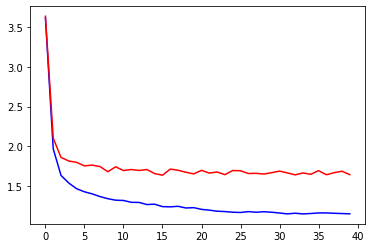

In [28]:
tr_loss = [t for t, v in lossi]
va_loss = [v for t, v in lossi]

plot.plot(tr_loss, "b")
plot.plot(va_loss, "r")

In [29]:
tr_loss = eval_split(model, shake_next_batch, "train", cfg.block_size, batch_size=32, eval_size=2056)
va_loss = eval_split(model, shake_next_batch, "valid", cfg.block_size, batch_size=32, eval_size=2056)

f"{tr_loss:.4f}", f"{va_loss:.4f}"

('1.1426', '1.6538')

In [30]:
print(model.sample(500))

sir.

JULIET:
Pasting Edward's grace is in they no more.

JULIET:
I cannot give it me but distrangely action.

JULIET:
A company of your resolve rich majesty;
Progest's meltness that were will make us.
Provost:
Poor like the except her was to lie again.

LADY CAPULET:
Methou wilt us yours, sir: I cannot see thy
man:
Pray, sir, but they do not let me buy to say
you have been but
a crafted which dews me slew to deep him.

JULIET:
No.

LADY CAPULET:
What, now? Nay, marry, you
officer:

JULIET:
So n


# Experiment 2: Pre-train and Fine-tune

In [31]:
model = Transformer(cfg)
model = model.to(device)
param_n = sum([_.numel() for _ in model.parameters()])

In [32]:
optim = torch.optim.Adam(model.parameters())
lossi = fit(book_next_batch, batch_size=32, epoch=10000, eval_n=20, optim=optim)

 0/20 [09:05:40]: 3.4727 3.4898
 1/20 [09:06:15]: 2.0707 2.0775
 2/20 [09:06:50]: 1.5411 1.5910
 3/20 [09:07:24]: 1.4555 1.5003
 4/20 [09:08:00]: 1.4194 1.5459
 5/20 [09:08:35]: 1.4407 1.4776
 6/20 [09:09:07]: 1.4253 1.3892
 7/20 [09:09:43]: 1.2366 1.4155
 8/20 [09:10:19]: 1.2703 1.4474
 9/20 [09:10:54]: 1.2749 1.2969
10/20 [09:11:29]: 1.2277 1.2406
11/20 [09:12:05]: 1.2849 1.2307
12/20 [09:12:41]: 1.1800 1.2625
13/20 [09:13:16]: 1.1926 1.1617
14/20 [09:13:51]: 1.2235 1.1747
15/20 [09:14:27]: 1.1717 1.1917
16/20 [09:15:04]: 1.2608 1.2299
17/20 [09:15:40]: 1.1498 1.3073
18/20 [09:16:17]: 1.1738 1.3302
19/20 [09:16:52]: 1.1341 1.1730


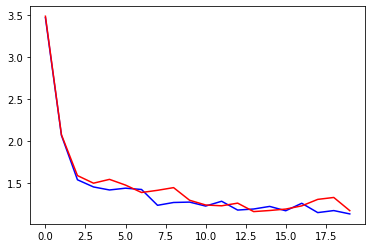

In [33]:
tr_loss = [t for t, v in lossi]
va_loss = [v for t, v in lossi]

plot.plot(tr_loss, "b")
plot.plot(va_loss, "r")

In [34]:
tr_loss = eval_split(model, book_next_batch, "train", cfg.block_size, batch_size=32, eval_size=2056)
va_loss = eval_split(model, book_next_batch, "valid", cfg.block_size, batch_size=32, eval_size=2056)

f"{tr_loss:.4f}", f"{va_loss:.4f}"

('1.1731', '1.2005')

In [35]:
print(model.sample(500))

''laugh .i knew good .her gaze was too there .`` i 'm the first i have an as she was going to hurt with such you should be hurted and tried to talk about the holes , '' i asked , whiping everything i needed , gently moving on anything , and i had n't blushed down .cause the way i had been of f__king breaking the baire calm that i ready the two sofara dimma was a long and darter ignore .she lecked from the door .`` it was someone ? ''i se in a did , hell , he worked and stood a phone in my life ,


### Fine-tuning

In [36]:
optim = torch.optim.Adam(model.parameters(), lr=0.0001) # default lr=0.001
lossi = fit(shake_next_batch, batch_size=32, epoch=5000, eval_n=20, optim=optim)

 0/20 [09:17:35]: 4.2916 4.4264
 1/20 [09:17:47]: 1.8348 1.8826
 2/20 [09:17:59]: 1.6713 1.7511
 3/20 [09:18:11]: 1.6076 1.7063
 4/20 [09:18:23]: 1.5380 1.6565
 5/20 [09:18:35]: 1.5117 1.6464
 6/20 [09:18:47]: 1.4828 1.6345
 7/20 [09:18:59]: 1.4493 1.6156
 8/20 [09:19:11]: 1.4358 1.6139
 9/20 [09:19:23]: 1.3989 1.5810
10/20 [09:19:35]: 1.3741 1.6108
11/20 [09:19:47]: 1.3699 1.5959
12/20 [09:19:59]: 1.3699 1.6227
13/20 [09:20:11]: 1.3609 1.5859
14/20 [09:20:23]: 1.3415 1.5683
15/20 [09:20:35]: 1.3103 1.5975
16/20 [09:20:47]: 1.3061 1.5778
17/20 [09:20:59]: 1.3058 1.5870
18/20 [09:21:11]: 1.3162 1.5497
19/20 [09:21:23]: 1.2984 1.5714


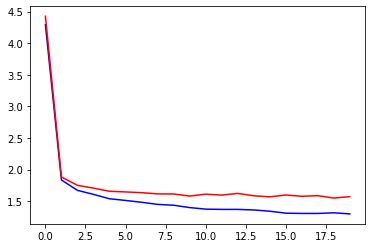

In [37]:
tr_loss = [t for t, v in lossi]
va_loss = [v for t, v in lossi]

plot.plot(tr_loss, "b")
plot.plot(va_loss, "r")

In [38]:
tr_loss = eval_split(model, shake_next_batch, "train", cfg.block_size, batch_size=32, eval_size=2056)
va_loss = eval_split(model, shake_next_batch, "valid", cfg.block_size, batch_size=32, eval_size=2056)

f"{tr_loss:.4f}", f"{va_loss:.4f}"

('1.2973', '1.5862')

In [40]:
print(model.sample(500))

'marry?

TANLET:
It may confess' father I swear, enough,
Tybalt, but no worth.

LEONTES:
He villain by that bloody here not the king, do.
BRUTUS:
Goo,
I'll not stay me before you there must do it.

KING RICHARD I:
Which is I to us; sir.

QUEN ELIZABETH:
This is no man good lord; foes, sir,
I cannot see him charge for yourselves by you.

GLOUCESTER:
You old it were slain for Norfolk.

LISABELLA:
The hatry smiles, may their disposed the parent,
They are not but comsended, there do your honour Rome
